In this Colab, we will use a keras Long Short-Term Memory (LSTM) model to predict the stock price of Tata Global Beverages


Here are some imports we need to make: numpy for scientific computation, matplotlib for graphing, and pandas for manipulating data.

In [ ]:
# Flyweight class to store intrinsic product data
class ProductFlyweight:
    def _init_(self, name, category, price):
        self.name = name
        self.category = category
        self.price = price

    def _repr_(self):
        return f"Product(name={self.name}, category={self.category}, price={self.price})"

# Flyweight Factory to manage shared flyweight instances
class ProductFlyweightFactory:
    _flyweights = {}

    @classmethod
    def get_flyweight(cls, name, category, price):
        key = (name, category, price)
        if key not in cls._flyweights:
            cls._flyweights[key] = ProductFlyweight(name, category, price)
        return cls._flyweights[key]

# The Product class stores extrinsic data (inventory level) and uses flyweight for shared intrinsic data
class Product:
    def _init_(self, name, category, price, inventory_level):
        self.flyweight = ProductFlyweightFactory.get_flyweight(name, category, price)
        self.inventory_level = inventory_level

    def update_inventory(self, new_level):
        self.inventory_level = new_level

    def get_inventory(self):
        return self.inventory_level

    def get_value(self):
        return self.flyweight.price * self.inventory_level

    def _repr_(self):
        return f"{self.flyweight} with inventory: {self.inventory_level}"

# Inventory Management class to handle all operations
class InventoryManager:
    def _init_(self):
        self.products = {}

    def add_product(self, name, category, price, inventory_level):
        if name not in self.products:
            self.products[name] = Product(name, category, price, inventory_level)
        else:
            print(f"Product {name} already exists. Updating inventory level.")
            self.products[name].update_inventory(inventory_level)

    def update_inventory(self, name, new_level):
        if name in self.products:
            self.products[name].update_inventory(new_level)
        else:
            print(f"Product {name} not found.")

    def get_inventory(self, name):
        if name in self.products:
            return self.products[name].get_inventory()
        else:
            print(f"Product {name} not found.")
            return None

    def calculate_total_value(self):
        total_value = sum(product.get_value() for product in self.products.values())
        return total_value

    def _repr_(self):
        return f"Inventory contains: {[str(p) for p in self.products.values()]}"

# Example usage
if _name_ == "_main_":
    # Create inventory manager
    inventory = InventoryManager()

    # Add products
    inventory.add_product("Harry Potter", "Books", 19.99, 10)
    inventory.add_product("iPhone", "Electronics", 999.99, 5)
    inventory.add_product("T-Shirt", "Clothing", 25.99, 20)

    # Update inventory
    inventory.update_inventory("Harry Potter", 15)

    # Get product inventory
    print(f"Harry Potter inventory: {inventory.get_inventory('Harry Potter')}")

    # Calculate total value of inventory
    print(f"Total inventory value: ${inventory.calculate_total_value()}")

    # Print the full inventory
    print(inventory)

Load training data set with the "Open" and "High" columns to use in our modeling.

In [ ]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:, 1:2].values

Let's take a look at the first five rows of our dataset

In [ ]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


Import MinMaxScaler from scikit-learn to scale our dataset into numbers between 0 and 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

We want our data to be in the form of a 3D array for our LSTM model. First, we create data in 60 timesteps and convert it into an array using NumPy. Then, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

In [ ]:
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Make the necessary imports from keras

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Add LSTM layer along with dropout layers to prevent overfitting. After that, we add a Dense layer that specifies a one unit output. Next, we compile the model using the adam optimizer and set the loss as the mean_squarred_error

In [7]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

model.fit(X_train,y_train,epochs=100,batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - loss: 0.0304
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.0032
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 0.0031
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 0.0025
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0022
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 0.0025
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0031
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - loss: 0.0021
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.0018
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - loss: 0.0017
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 0.0017
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0019
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0015
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0016
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━

Import the test set for the model to make predictions on

In [8]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/tatatest.csv'
dataset_test = pd.read_csv(url)
real_stock_price = dataset_test.iloc[:, 1:2].values

Before predicting future stock prices, we have to manipulate the training set; we merge the training set and the test set on the 0 axis, set the time step to 60, use minmaxscaler, and reshape the dataset as done previously. After making predictions, we use inverse_transform to get back the stock prices in normal readable format.


In [9]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


Plot our predicted stock prices and the actual stock price

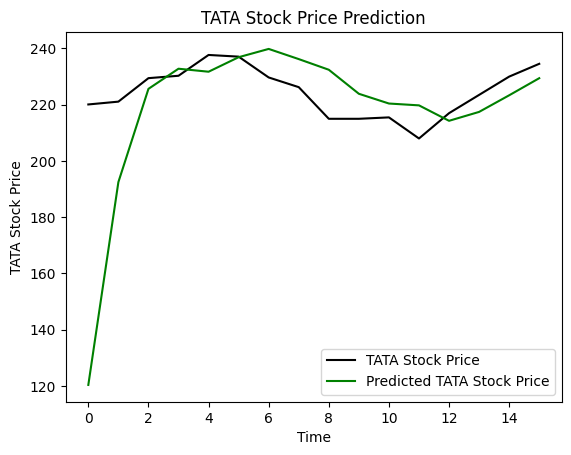

In [ ]:
plt.plot(real_stock_price, color = 'black', label = 'TATA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()